## Delay

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Importing the dataset
file_path = "Diagnostic_Delay_TimeSeries_10years.csv"
df = pd.read_csv(file_path)
df.head()

,Date,Total Activity,Total Waiting List,Waiting List test,6+ Week wait,6+ Week Wait %,13+ Weekwait
0,01/03/2015,263843,165161,226235,1400,0.85,115
1,01/04/2015,244709,164838,208217,1574,0.95,47
2,01/05/2015,248518,164769,211366,1718,1.04,75
3,01/06/2015,260740,174601,217912,1779,1.02,160
4,01/07/2015,269237,178862,224594,1598,0.89,97


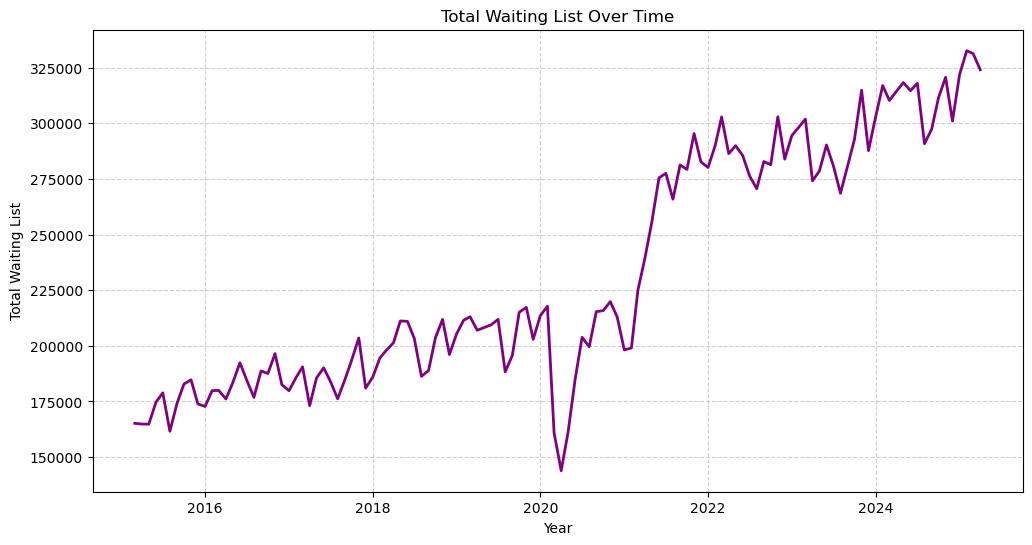

In [12]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Plot only the Waiting List
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Total Waiting List'], color='purple', linewidth=2)
plt.title('Total Waiting List Over Time')
plt.xlabel('Year')
plt.ylabel('Total Waiting List')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

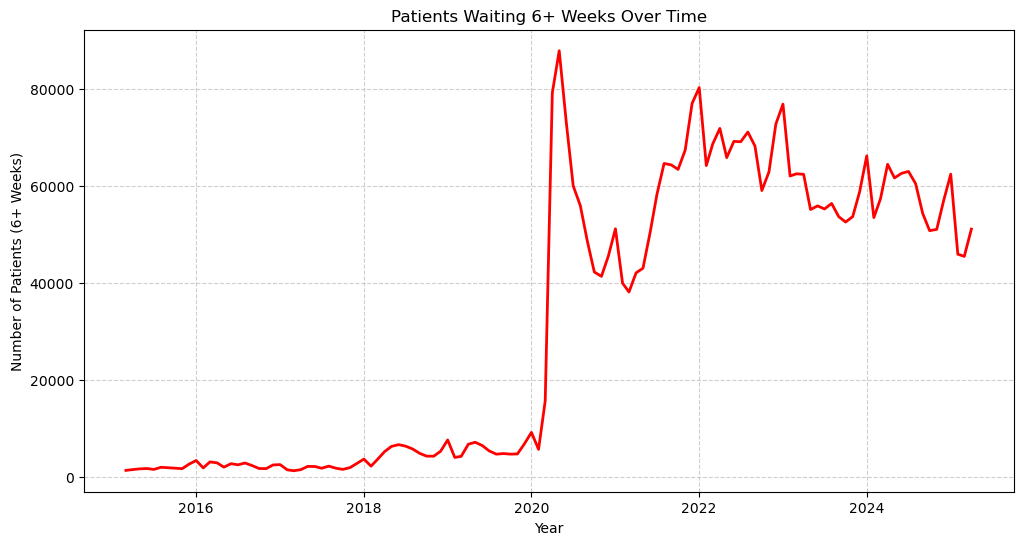

In [10]:
# Plot 6+ Week Wait
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['6+ Week wait'], color='red', linewidth=2)
plt.title('Patients Waiting 6+ Weeks Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Patients (6+ Weeks)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

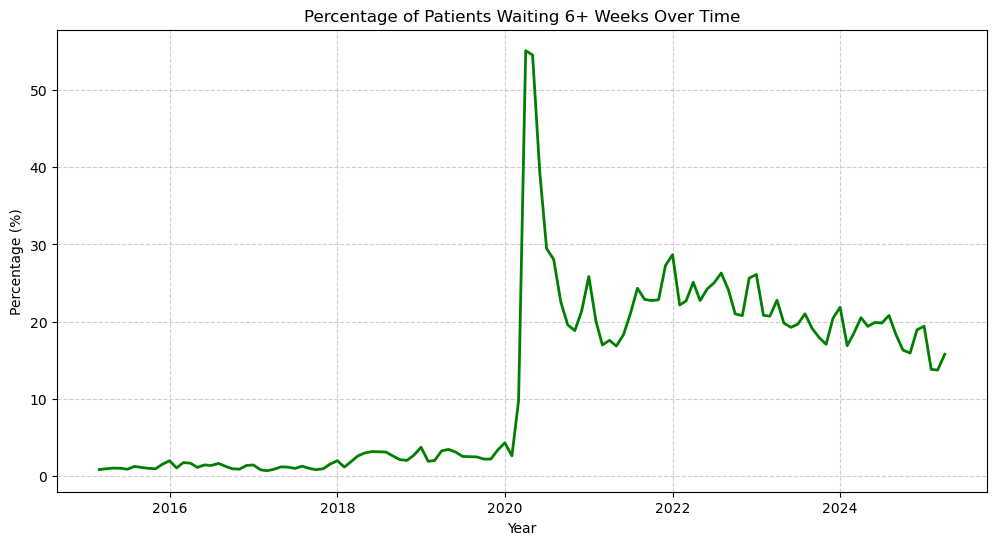

In [7]:


# Plot 6+ Week Wait Percentage
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['6+ Week Wait %'], color='green', linewidth=2)
plt.title('Percentage of Patients Waiting 6+ Weeks Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


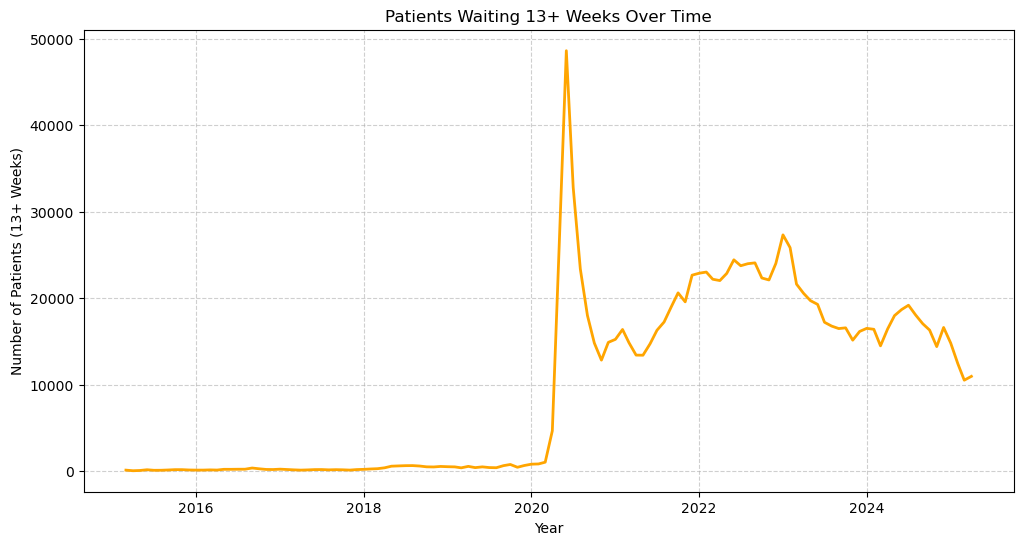

In [11]:
# Plot 13+ Week Wait (Line Chart)
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['13+ Weekwait'], color='orange', linewidth=2)
plt.title('Patients Waiting 13+ Weeks Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Patients (13+ Weeks)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
import pandas as pd
from pathlib import Path

# ---------- File paths (edit these to match your system) ----------
delay_path = Path("Diagnostic_Delay_TimeSeries_10years.csv")
mri_path   = Path("TotalMRI_Timeseries.csv")
out_path   = Path("combined_mri_delay_timeseries.csv")

# ---------- Load data ----------
delay_df = pd.read_csv(delay_path)
mri_df   = pd.read_csv(mri_path)

# ---------- Parse dates ----------
# Delay file uses day-first dates (e.g., 01/03/2015 -> 1 Mar 2015)
delay_df["Date"] = pd.to_datetime(delay_df["Date"], dayfirst=True)

# MRI file has provider-level rows; parse dates and coerce any bad values to NaT
mri_df["Date"] = pd.to_datetime(mri_df["Date"], dayfirst=True, errors="coerce")

# Make sure MRI counts are numeric
mri_df["Total MRI Scans"] = pd.to_numeric(mri_df["Total MRI Scans"], errors="coerce")

# ---------- Aggregate MRI to national/monthly totals ----------
mri_agg = (
    mri_df
    .dropna(subset=["Date"])                      # drop rows with invalid dates
    .groupby("Date", as_index=False)["Total MRI Scans"]
    .sum()
)

# ---------- Select required delay columns ----------
delay_selected = delay_df[["Date", "Total Waiting List", "6+ Week wait"]].copy()

# ---------- Merge on Date ----------
# Use 'inner' to keep only months present in BOTH datasets.
# Change to how="outer" if you prefer to keep all dates from either side.
combined = (
    pd.merge(mri_agg, delay_selected, on="Date", how="inner")
      .sort_values("Date")
      .reset_index(drop=True)
)

# (Optional) sanity checks
print("MRI date range:", mri_agg["Date"].min().date(), "to", mri_agg["Date"].max().date())
print("Delay date range:", delay_selected["Date"].min().date(), "to", delay_selected["Date"].max().date())
print("Combined rows:", len(combined))
print(combined.head())

# ---------- Save to CSV ----------
combined.to_csv(out_path, index=False)
print(f"\nSaved combined dataset to: {out_path.resolve()}")

# ---------- (Optional) add derived fields ----------
# If you later want 6+ week wait as a percentage of the total waiting list:
# combined["6+ Week Wait %"] = (combined["6+ Week wait"] / combined["Total Waiting List"]) * 100
# combined.to_csv(out_path, index=False)


MRI date range: 2016-04-01 to 2025-03-01
Delay date range: 2015-03-01 to 2025-04-01
Combined rows: 107
        Date  Total MRI Scans  Total Waiting List  6+ Week wait
0 2016-04-01         272155.0              176113          2953
1 2016-05-01         265410.0              183393          2071
2 2016-06-01         277195.0              192393          2781
3 2016-07-01         279035.0              184475          2546
4 2016-08-01         276805.0              176844          2921

Saved combined dataset to: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\EDA\combined_mri_delay_timeseries.csv


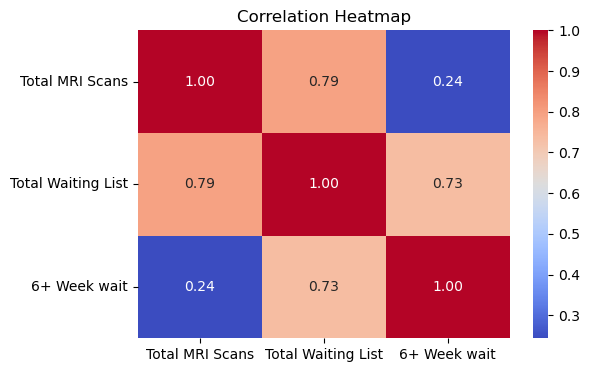

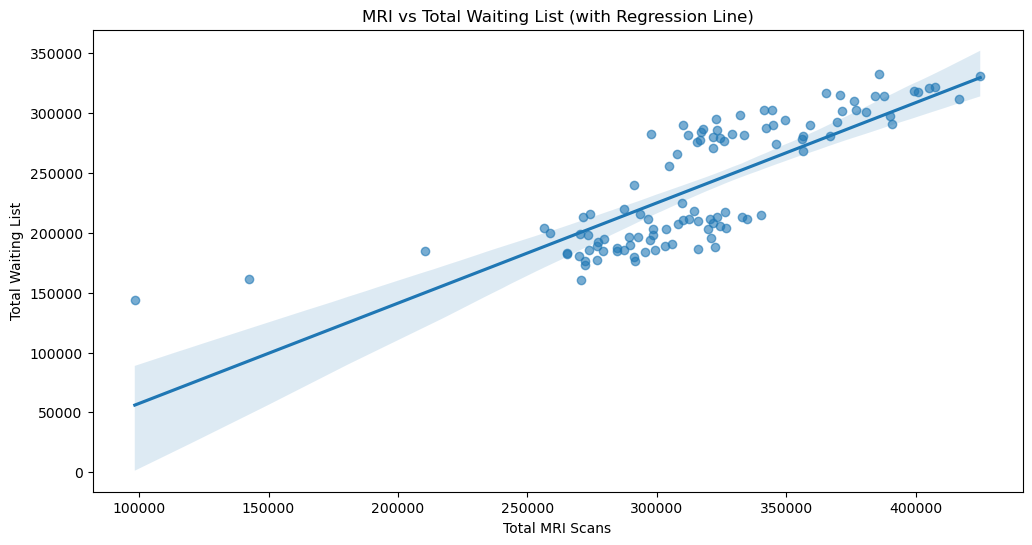

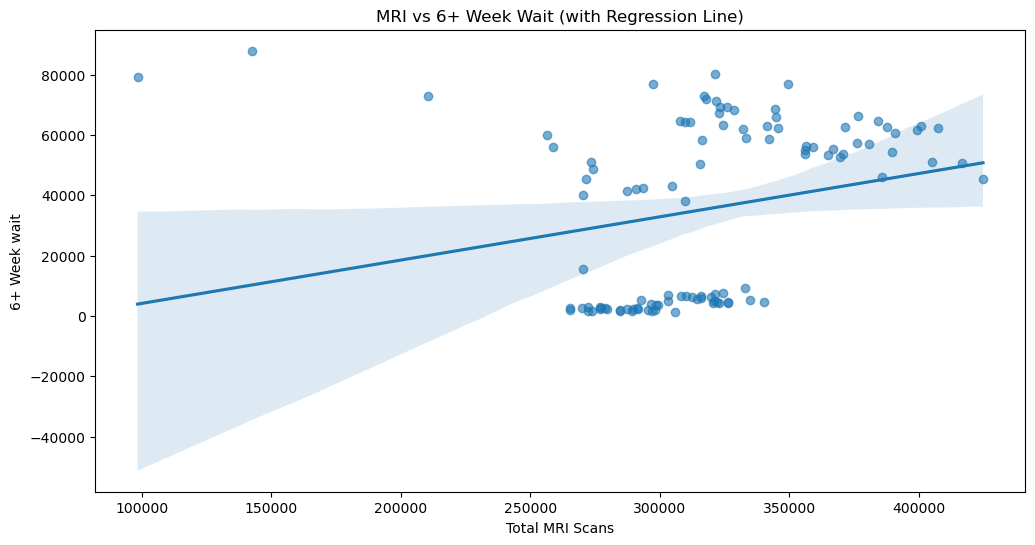

R² MRI vs Waiting List: 0.6318506446005103
R² MRI vs 6+ Week Wait: 0.05928974313394764


In [15]:

import seaborn as sns
import statsmodels.api as sm

# -------------------
# Load the dataset
# -------------------
file_path = "combined_mri_delay_timeseries.csv"   # update path if needed
df = pd.read_csv(file_path)

# Parse dates
df["Date"] = pd.to_datetime(df["Date"])

# -------------------
# Correlation heatmap
# -------------------
corr = df[["Total MRI Scans", "Total Waiting List", "6+ Week wait"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# -------------------
# Scatter + regression lines
# -------------------
plt.figure(figsize=(12,6))
sns.regplot(x="Total MRI Scans", y="Total Waiting List", data=df, scatter_kws={'alpha':0.6})
plt.title("MRI vs Total Waiting List (with Regression Line)")
plt.show()

plt.figure(figsize=(12,6))
sns.regplot(x="Total MRI Scans", y="6+ Week wait", data=df, scatter_kws={'alpha':0.6})
plt.title("MRI vs 6+ Week Wait (with Regression Line)")
plt.show()

# -------------------
# Calculate R² values
# -------------------
X1 = sm.add_constant(df["Total MRI Scans"])
y1 = df["Total Waiting List"]
model1 = sm.OLS(y1, X1).fit()

X2 = sm.add_constant(df["Total MRI Scans"])
y2 = df["6+ Week wait"]
model2 = sm.OLS(y2, X2).fit()

print("R² MRI vs Waiting List:", model1.rsquared)
print("R² MRI vs 6+ Week Wait:", model2.rsquared)



C:\Users\PAVILION\AppData\Local\Temp\ipykernel_2208\2823556520.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"], errors="coerce")


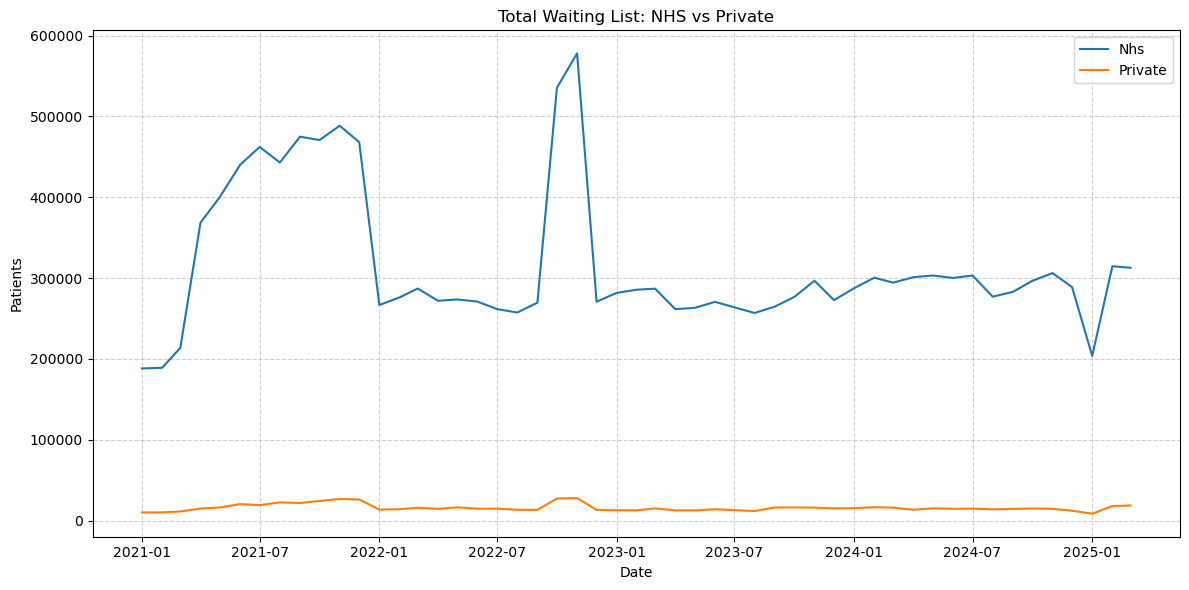

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Load & Clean ----------
file_path = "Delay_data_per_trust_2020-25.csv"   # update path if needed
df = pd.read_csv(file_path)

# Strip column names of spaces
df = df.rename(columns=lambda x: x.strip())

# Clean numeric columns
for col in ["Total Waiting List", "Number waiting 6+ Weeks", "Number waiting 13+ Weeks"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.strip()
        .replace({"": None, "nan": None})
        .astype(float)
    )

# Normalize hospital type (force to title-case and strip spaces)
df["Type of Hospital"] = df["Type of Hospital"].astype(str).str.strip().str.title()

# Build proper Date column
df["Year"] = df["Year"].astype("Int64")
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"], errors="coerce")

# ---------- Plot function ----------
def plot_timeseries_by_type(df, value_col, title, ylabel):
    monthly = (
        df.groupby(["Date", "Type of Hospital"], as_index=False)[value_col]
          .sum()
          .sort_values("Date")
    )

    plt.figure(figsize=(12,6))
    for t in monthly["Type of Hospital"].unique():  # loop over whatever exists (NHS, Private)
        sub = monthly[monthly["Type of Hospital"] == t]
        plt.plot(sub["Date"], sub[value_col], label=t)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# ---------- Example ----------
plot_timeseries_by_type(df, "Total Waiting List", "Total Waiting List: NHS vs Private", "Patients")


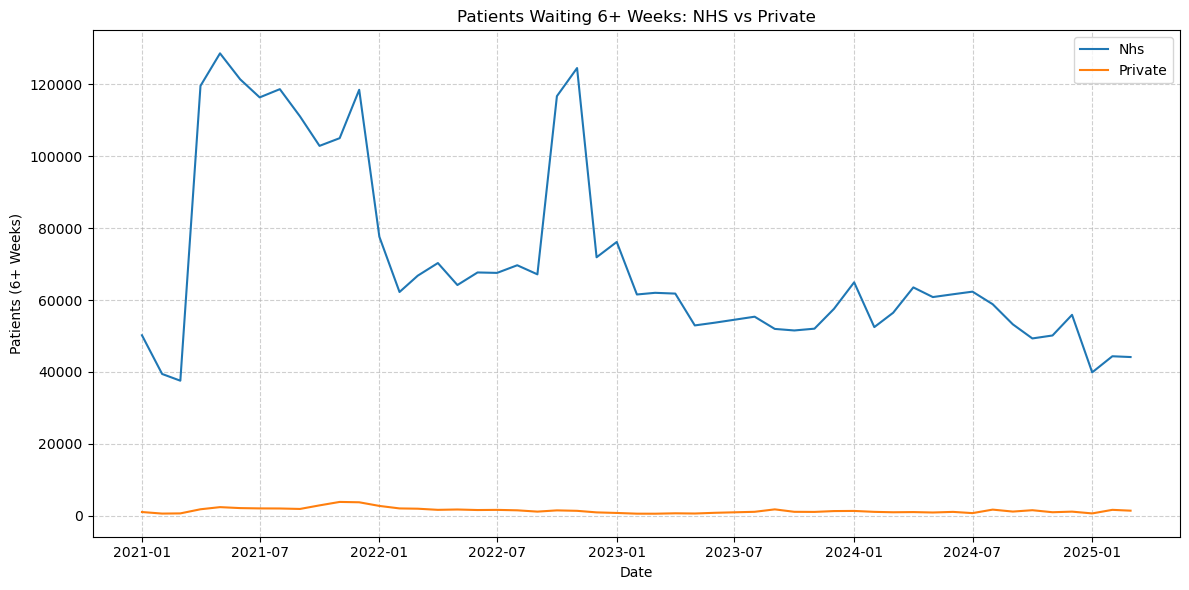

In [18]:
# ---------- Example: 6+ Week Cases ----------
plot_timeseries_by_type(df,
    value_col="Number waiting 6+ Weeks",
    title="Patients Waiting 6+ Weeks: NHS vs Private",
    ylabel="Patients (6+ Weeks)"
)

C:\Users\PAVILION\AppData\Local\Temp\ipykernel_2208\2290753142.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"], errors="coerce")


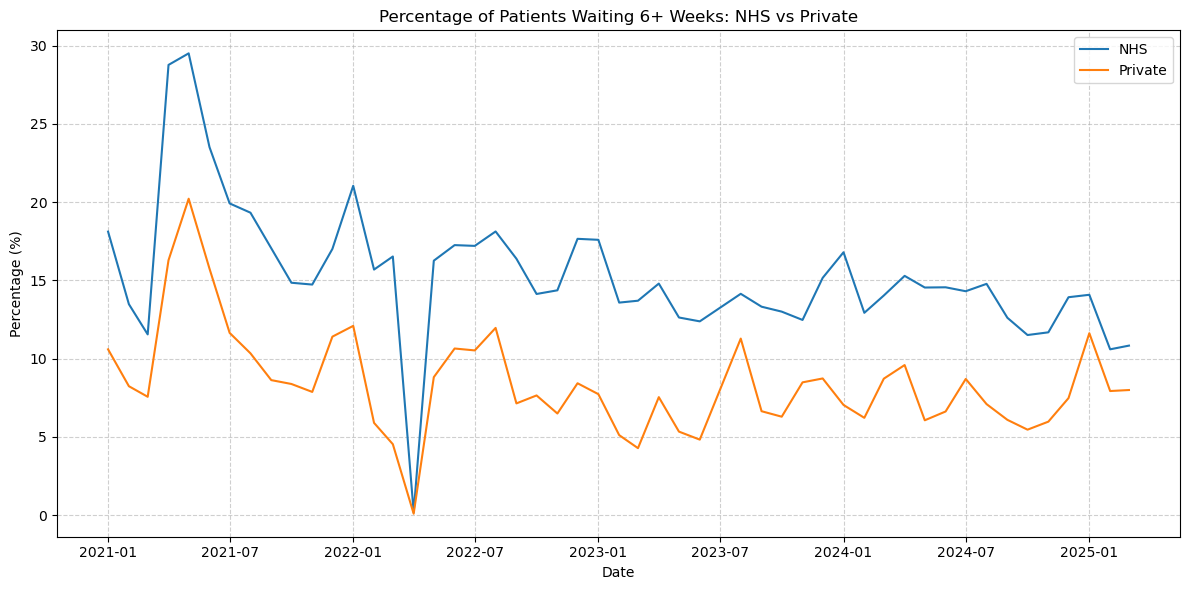

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Load & Clean ----------
file_path = "Delay_data_per_trust_2020-25.csv"   # update path if needed
df = pd.read_csv(file_path)

# Strip spaces from column names
df = df.rename(columns=lambda x: x.strip())

# Clean numeric columns
for col in ["Total Waiting List", "Number waiting 6+ Weeks", "Number waiting 13+ Weeks"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.strip()
        .replace({"": None, "nan": None})
        .astype(float)
    )

# Clean percentage column (remove % sign, convert to float)
df["Percentage waiting 6+ weeks"] = (
    df["Percentage waiting 6+ weeks"]
    .astype(str)
    .str.replace("%", "")
    .str.strip()
    .replace({"": None, "nan": None})
    .astype(float)
)

# Normalize hospital type → only "NHS" and "Private"
df["Type of Hospital"] = df["Type of Hospital"].str.strip().str.title()
df["Type of Hospital"] = df["Type of Hospital"].replace({"Nhs": "NHS", "Private": "Private"})

# Build Date column
df["Year"] = df["Year"].astype("Int64")
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"], errors="coerce")

# ---------- Reusable Plot Function ----------
def plot_timeseries_by_type(df, value_col, title, ylabel):
    monthly = (
        df.groupby(["Date", "Type of Hospital"], as_index=False)[value_col]
          .mean()   # for percentages, mean across trusts makes sense
          .sort_values("Date")
    )

    plt.figure(figsize=(12,6))
    for t in ["NHS", "Private"]:
        sub = monthly[monthly["Type of Hospital"] == t]
        if not sub.empty:
            plt.plot(sub["Date"], sub[value_col], label=t)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# ---------- Example: 6+ Week Percent ----------
plot_timeseries_by_type(
    df,
    value_col="Percentage waiting 6+ weeks",
    title="Percentage of Patients Waiting 6+ Weeks: NHS vs Private",
    ylabel="Percentage (%)"
)


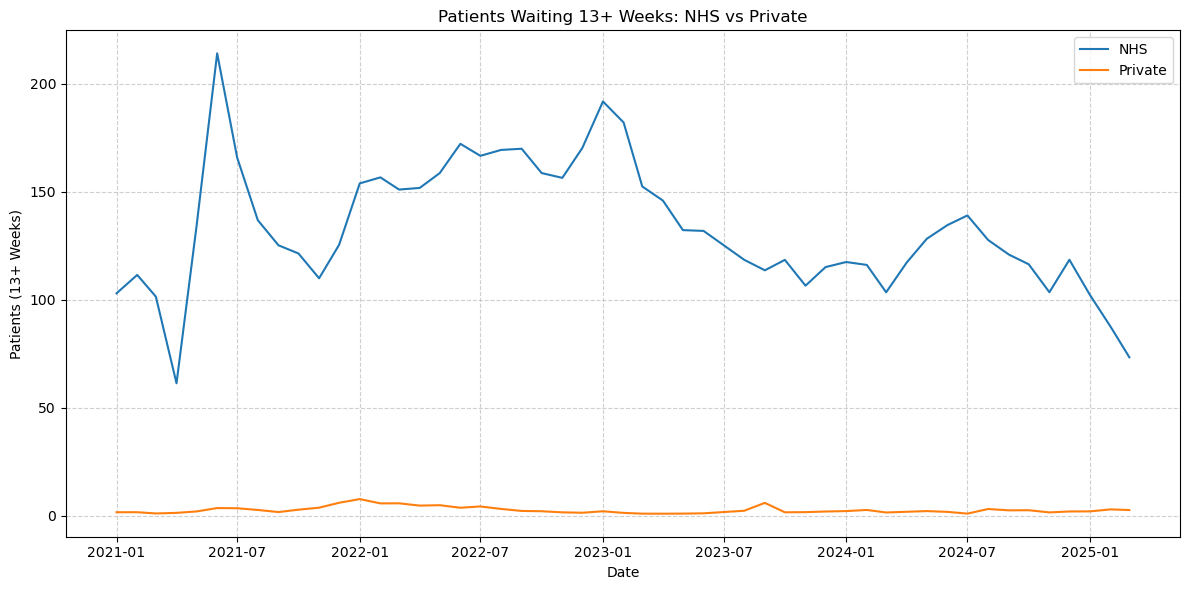

In [21]:
# ---------- Example: 13+ Week Cases ----------
plot_timeseries_by_type(
    df,
    value_col="Number waiting 13+ Weeks",
    title="Patients Waiting 13+ Weeks: NHS vs Private",
    ylabel="Patients (13+ Weeks)"
)
